In [44]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt




In [52]:
import glob
import os
from pathlib import Path
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

# Paths
root_dir = Path("dataset_20/all_20")  # Folder containing 'cluster' and 'non_cluster'
output_dir = Path("processed_images")
output_dir.mkdir(parents=True, exist_ok=True)

# Label mapping
label_map = {
    'cluster': 0,
    'non_cluster': 1
}

# Storage for file paths and labels
file_paths = []
labels = []

# Iterate over each category
for category, label in label_map.items():
    category_path = root_dir / category
    fits_files = glob.glob(str(category_path / "**" / "*.fits"), recursive=True)
    
    for fits_file in fits_files:
        try:
            # Open FITS file
            with fits.open(fits_file) as hdul:
                img_data = hdul[0].data

            # Handle NaNs and negatives for log scaling
            img_data = np.nan_to_num(img_data, nan=0.0)
            img_data[img_data < 0] = 0  # Clip negatives to zero

            # Apply log normalization
            img_data = np.log1p(img_data)  # log(1 + x) to handle zeros
            img_min, img_max = np.min(img_data), np.max(img_data)
            if img_max > img_min:
                img_data = (img_data - img_min) / (img_max - img_min)

            # Save as PNG in output directory with same subfolder name
            category_out = output_dir / category
            category_out.mkdir(parents=True, exist_ok=True)
            png_name = Path(fits_file).stem + ".png"
            png_path = category_out / png_name

            plt.imsave(png_path, img_data, cmap='gray')

            # Record path and label
            file_paths.append(str(png_path))
            labels.append(label)

        except Exception as e:
            print(f"Error processing {fits_file}: {e}")

print(f"Processed {len(file_paths)} files.")


Processed 20 files.


In [53]:
# Config
DATA_DIR = Path("processed_images")
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 10
NUM_WORKERS = os.cpu_count()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

eval_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load full dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=eval_transform)

# Split into train (70%), val (15%), test (15%)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply train transforms only to train dataset
train_dataset.dataset.transform = train_transform

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


In [55]:
class clusterCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE//8) * (IMG_SIZE//8), 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = clusterCNN().to(DEVICE)


In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.6872
Epoch [2/10], Loss: 0.7097
Epoch [3/10], Loss: 0.7152
Epoch [4/10], Loss: 0.6615
Epoch [5/10], Loss: 0.6418
Epoch [6/10], Loss: 0.6491
Epoch [7/10], Loss: 0.7451
Epoch [8/10], Loss: 0.6724
Epoch [9/10], Loss: 0.6781
Epoch [10/10], Loss: 0.6536


In [57]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    running_loss = 0
    for images, labels in test_loader:  # or validation_loader
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Get predicted class
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


Test Loss: 0.6158, Accuracy: 66.67%


In [58]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=['cluster', 'Non-cluster']))


              precision    recall  f1-score   support

    Globular       0.67      1.00      0.80         2
Non-Globular       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



/opt/anaconda3/envs/cnn_gc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/cnn_gc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/cnn_gc/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[2 0]
 [1 0]]


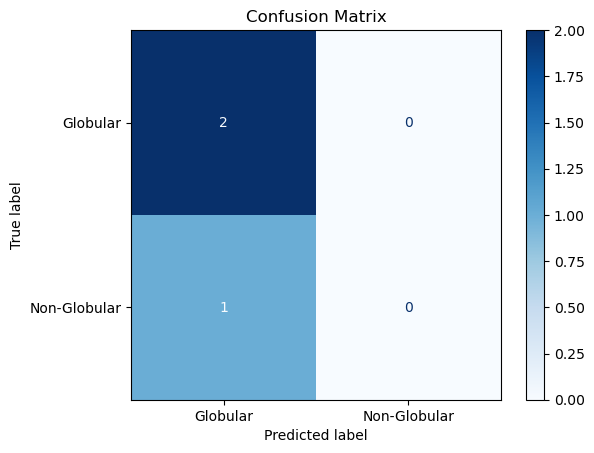

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cluster', 'Non-cluster'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

